<a href="https://colab.research.google.com/github/benigmatic/Quantum-circuits/blob/main/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from qiskit import *

In [ ]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector


In [ ]:
#Quantum Fourier transform: 3-qubit QFT
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr, cr)

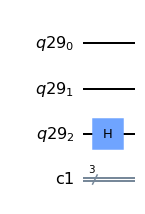

In [ ]:
qc.h(2)
qc.draw(output="mpl")


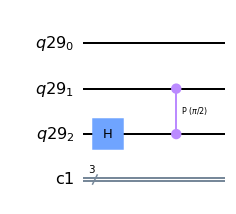

In [ ]:
qc.cp(pi/2, 1, 2) # CROT from qubit 1 to qubit 2
qc.draw(output="mpl")


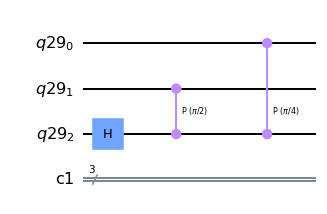

In [ ]:
qc.cp(pi/4, 0, 2) # CROT from qubit 2 to qubit 0
qc.draw(output="mpl")


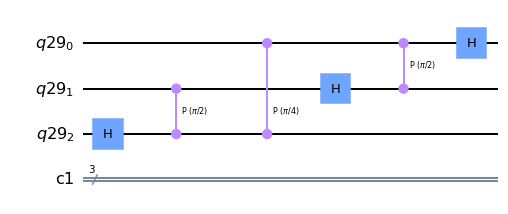

In [ ]:
qc.h(1)
qc.cp(pi/2, 0, 1) # CROT from qubit 0 to qubit 1
qc.h(0)
qc.draw(output="mpl")


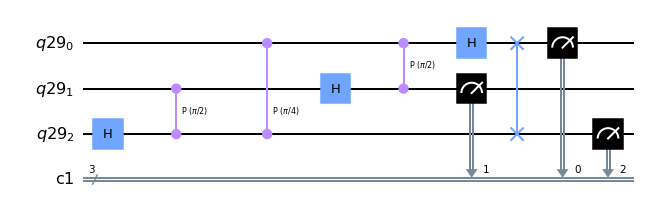

In [ ]:
qc.swap(0,2)
qc.measure(qr,cr)
qc.draw(output="mpl")


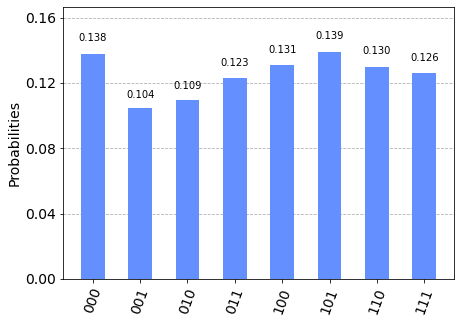

In [ ]:
# Testing version 1
#Test on clasical simulation (Version 1)
simulator = Aer.get_backend('qasm_simulator')
from qiskit.tools.visualization import plot_histogram
 #Execute the circuit (simulation)

result = execute(qc, backend=simulator).result()
plot_histogram(result.get_counts(qc))

C:\Users\krivo\AppData\Local\Temp/ipykernel_2612/462170379.py:6: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circuit += QFT(num_qubits=3, approximation_degree=0, do_swaps=True, inverse=False, insert_barriers=False, name='qft')


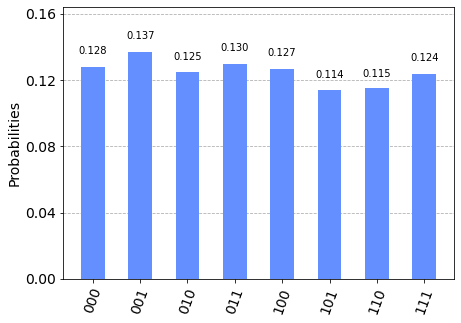

In [ ]:
from qiskit.circuit.library import QFT

q = QuantumRegister(3,'q')
c = ClassicalRegister(3,'c')
circuit = QuantumCircuit(q,c)
circuit += QFT(num_qubits=3, approximation_degree=0, do_swaps=True, inverse=False, insert_barriers=False, name='qft')
circuit.measure(q,c)

simulator = Aer.get_backend('qasm_simulator')
from qiskit.tools.visualization import plot_histogram
 #Execute the circuit (simulation)
result = execute(circuit, backend=simulator).result()
plot_histogram(result.get_counts(circuit))

In [ ]:
def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
   
    qft_rotations(circuit, n)

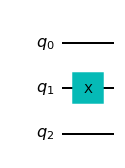

In [ ]:

# test on simulator
"""Basis vector |010 >"""

# Create the circuit
circuit = QuantumCircuit(3)

# Encode the state |010 >

circuit.x(1)
circuit.draw(output="mpl")


Statevector([ 3.53553391e-01-4.32978028e-17j,
              6.49467042e-17+3.53553391e-01j,
             -3.53553391e-01+4.32978028e-17j,
             -6.49467042e-17-3.53553391e-01j,
              3.53553391e-01-4.32978028e-17j,
              6.49467042e-17+3.53553391e-01j,
             -3.53553391e-01+4.32978028e-17j,
             -6.49467042e-17-3.53553391e-01j],
            dims=(2, 2, 2))


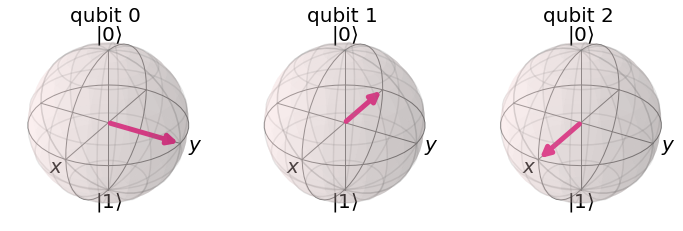

In [ ]:
# copy the created QFT circuit to the basis state
sim = Aer.get_backend("aer_simulator")
qc_init = qft(circuit, 3)
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
print(statevector)
plot_bloch_multivector(statevector)


In [ ]:

"""In this output we can see that the phases of all terms incremented by value of pi/2 radians
for the given basis state"""

'In this output we can see that thaphases of all terms incremented by value of pi/2 radians\nfor the given basis state'

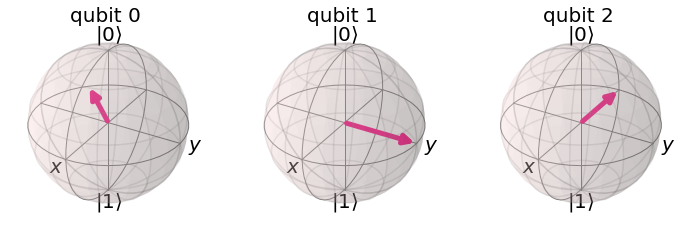

In [ ]:
#Run on real quantum computer (version 2)
"""In order to test it on real device and avoid completely random answers due to superposition
we can proove that QFT is working if we create the state and then run QFT 
in reverse to verify that output would match."""
# reverse QFT 
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates
nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)

qc.draw()
qc_init = qc.copy()
qc_init.save_statevector()
sim = Aer.get_backend("aer_simulator")
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)



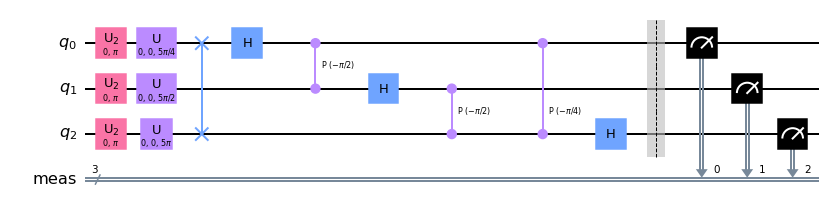

In [ ]:
# Apply inverse
qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw(output="mpl")

In [ ]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)


ibmqfactory.load_account:WARNING:2022-03-20 14:54:27,283: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_lima


In [ ]:
shots = 2048
transpiled_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_qc, shots=shots)
job_monitor(job)


Job Status: job has successfully run


In [ ]:
print(job.result().get_counts())

{'000': 49, '001': 158, '010': 12, '011': 97, '100': 162, '101': 1440, '110': 35, '111': 95}


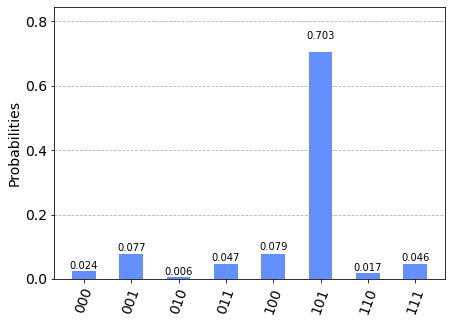

In [ ]:
counts = job.result().get_counts()
plot_histogram(counts)
